#### 1. Environment Setup & Data Loading

In [1]:
!pip install catboost
!pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    f1_score, 
    roc_auc_score,
    silhouette_score 
)

# --- Display Settings and Warning Handling ---
pd.set_option('display.max_columns', None) # Display all columns
import warnings
warnings.filterwarnings('ignore') # Mute non-critical warnings

print("All libraries imported successfully.")

# --- Load Data ---
# Update this path to your folder


adir=0
if(adir==1):
    base_path = r"C:\Users\Adir\Documents\NYPD-ML-Predictor\data"
else:
    base_path = r"C:\Users\97252\Desktop\Chen_proj\data"

print("Loading datasets...")

# Load Features (X)
X_train = pd.read_csv(f"{base_path}/X_train.csv")
X_train_noisy = pd.read_csv(f"{base_path}/X_train_noisy.csv") # For experiments
X_test = pd.read_csv(f"{base_path}/X_test.csv")

# Load Targets (y) - using squeeze to make them Series
y_train = pd.read_csv(f"{base_path}/y_train.csv").squeeze()
y_test = pd.read_csv(f"{base_path}/y_test.csv").squeeze()

print(f"Data Loaded. Train Shape: {X_train.shape}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


All libraries imported successfully.
Loading datasets...
Data Loaded. Train Shape: (23795, 23)


In [2]:
!pip install jinja2


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


##### 2. Advanced Feature Engineering

In [3]:
# --- 1. Function Definition ---
def apply_feature_engineering(df):
    # Create a copy to avoid accidentally modifying the original data
    df = df.copy()

    # 1. Demographic Interactions
    # Check if race matches (ignoring Unknowns)
    df['same_race'] = ((df['PERP_RACE'] == df['VIC_RACE']) & 
                        (df['PERP_RACE'] != 'Unknown')).astype(int)
    
    # Is the suspect information available or missing?
    df['suspect_info_available'] = (df['PERP_AGE_GROUP'] != 'Unknown').astype(int)

    # 2. Cyclical Time Features
    # This helps models understand that 23:00 is close to 00:00
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # 3. Specific Risk Combinations
    # Crimes happening outside at night might have different characteristics
    df['is_night_outdoor'] = ((df['Part_of_Day'] == 'Night') & 
                              (df['LOC_OF_OCCUR_DESC'] == 'OUTSIDE')).astype(int)

    # 4. Vulnerability Features
    # Flagging minor victims
    df['is_minor_victim'] = (df['VIC_AGE_GROUP'] == '<18').astype(int)
    
    return df

# --- 2. Applying the Function to All Sets ---
print("Applying feature engineering...")
X_train = apply_feature_engineering(X_train)
X_train_noisy = apply_feature_engineering(X_train_noisy)
X_test = apply_feature_engineering(X_test)

print("Feature engineering complete. New columns added.")
print(f"New columns: {[col for col in X_train.columns if col not in ['X_COORD_CD', 'Y_COORD_CD']]}") # Print example

Applying feature engineering...
Feature engineering complete. New columns added.
New columns: ['BORO', 'LOC_OF_OCCUR_DESC', 'PRECINCT', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'LOCATION_GROUP', 'Month', 'DayOfWeek', 'Hour', 'Part_of_Day', 'is_weekend', 'holiday_name', 'is_holiday', 'Season', 'same_race', 'suspect_info_available', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'is_night_outdoor', 'is_minor_victim']


#### 3. Handling High Cardinality

--- Distribution Analysis (Top 20 Categories) ---


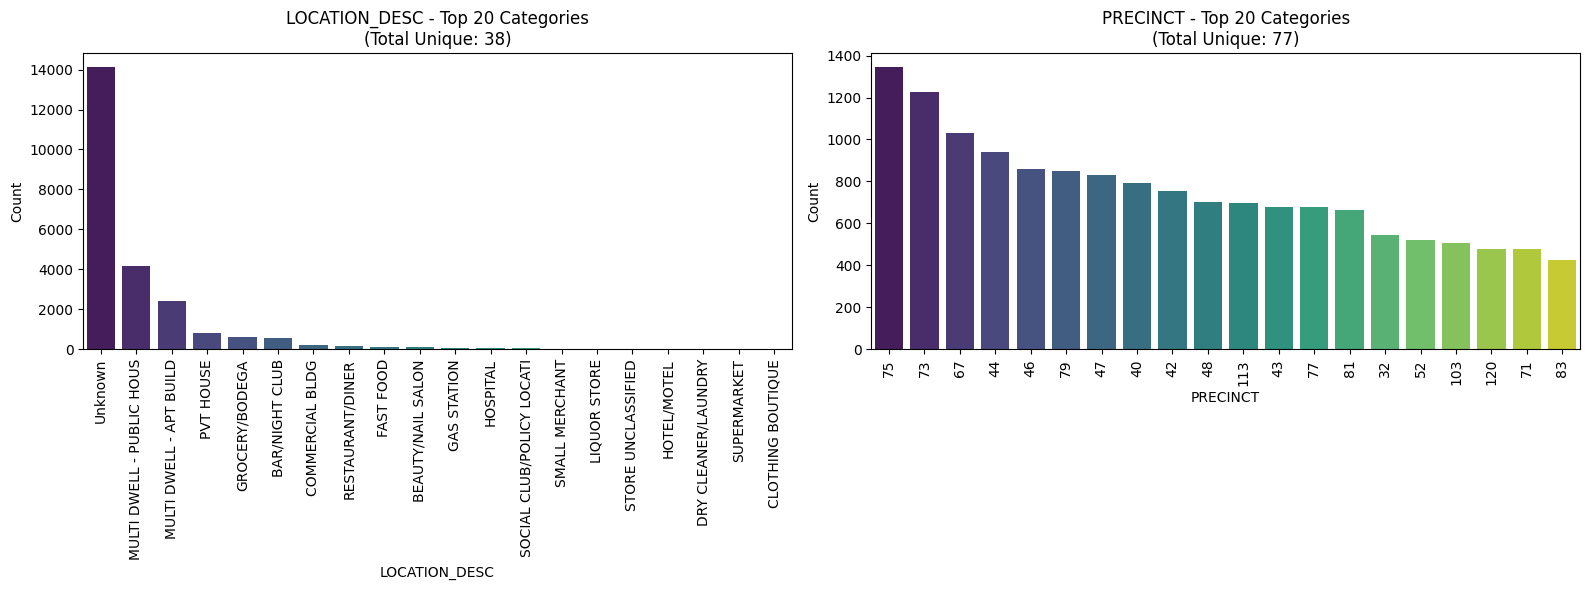


Column 'LOCATION_DESC' has 38 unique categories.
Bottom 5 rare categories (Candidates for 'Other'):
LOCATION_DESC
CHECK CASH          1
ATM                 1
LOAN COMPANY        1
STORAGE FACILITY    1
PHOTO/COPY STORE    1
Name: count, dtype: int64

Column 'PRECINCT' has 77 unique categories.
Bottom 5 rare categories (Candidates for 'Other'):
PRECINCT
1      20
112    17
111    12
17      8
22      1
Name: count, dtype: int64


In [4]:
# --- Preparing Data for Analysis ---
# We convert PRECINCT to string because we will soon insert the value "Other" (string)
# and we cannot mix numbers and strings in the same column without converting them all to Object/Category
X_train['PRECINCT'] = X_train['PRECINCT'].astype(str)
X_test['PRECINCT'] = X_test['PRECINCT'].astype(str)

cols_to_analyze = ['LOCATION_DESC', 'PRECINCT']

print("--- Distribution Analysis (Top 20 Categories) ---")

plt.figure(figsize=(16, 6))
for i, col in enumerate(cols_to_analyze):
    plt.subplot(1, 2, i+1)
    
    # Calculate frequency
    counts = X_train[col].value_counts()
    
    # Display top 20 most common categories
    sns.barplot(x=counts.head(20).index, y=counts.head(20).values, palette='viridis')
    plt.title(f'{col} - Top 20 Categories\n(Total Unique: {counts.shape[0]})')
    plt.xticks(rotation=90)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Textual print to see the "tail" (rare categories)
for col in cols_to_analyze:
    n_unique = X_train[col].nunique()
    print(f"\nColumn '{col}' has {n_unique} unique categories.")
    print("Bottom 5 rare categories (Candidates for 'Other'):")
    print(X_train[col].value_counts().tail(5))

##### 2.3 Cardinality Reduction: Grouping Rare Labels

In [5]:
# --- Helper Functions for Reduction ---
def get_top_categories(df, col, threshold=0.005):
    """ 
    Returns a list of categories that appear in more than 'threshold' percent of the rows.
    Based on Training Data ONLY.
    """
    counts = df[col].value_counts(normalize=True) # Calculate percentages
    top_cats = counts[counts > threshold].index.tolist()
    return top_cats

def apply_cardinality_reduction(df, col_map):
    """
    Applies the grouping logic: Keep top categories, replace rest with 'Other'.
    """
    df_clean = df.copy()
    for col, allowed_cats in col_map.items():
        if col in df_clean.columns:
            # The lambda function checks membership in the allowed list
            df_clean[col] = df_clean[col].apply(lambda x: x if x in allowed_cats else 'Other')
    return df_clean

# --- Execution Strategy ---

# 1. Define Settings
# Thresholds:
# LOCATION_DESC: 0.5% (0.005) -> Removes very specific/rare locations.
# PRECINCT: 0.2% (0.002) -> Keeps most stations, removes errors/typos only.
threshold_settings = {
    'LOCATION_DESC': 0.005, 
    'PRECINCT': 0.002       
}

reduction_map = {}

# 2. Fit (Learn from Train)
print("Learning frequent categories from Train set...")
for col, thresh in threshold_settings.items():
    if col in X_train.columns:
        top_cats = get_top_categories(X_train, col, threshold=thresh)
        reduction_map[col] = top_cats
        
        # Log the reduction info
        original_count = X_train[col].nunique()
        new_count = len(top_cats) + 1 # +1 for 'Other'
        print(f" -> Column '{col}': Reduced from {original_count} to {new_count} categories (Threshold: {thresh*100}%)")

# 3. Transform (Apply to Train & Test)
print("\nApplying reduction to Train and Test sets...")
X_train_reduced = apply_cardinality_reduction(X_train, reduction_map)
X_test_reduced = apply_cardinality_reduction(X_test, reduction_map)

# 4. Verify Result
print("\nSanity Check (PRECINCT after reduction):")
print(X_train_reduced['PRECINCT'].value_counts().tail())

Learning frequent categories from Train set...
 -> Column 'LOCATION_DESC': Reduced from 38 to 9 categories (Threshold: 0.5%)
 -> Column 'PRECINCT': Reduced from 77 to 66 categories (Threshold: 0.2%)

Applying reduction to Train and Test sets...

Sanity Check (PRECINCT after reduction):
PRECINCT
10     62
5      61
62     58
13     50
122    50
Name: count, dtype: int64



We addressed the high cardinality in categorical features using a frequency-based thresholding approach. To prevent **Data Leakage**, the "popular" categories were identified solely from the **Training Set**, and then applied to the Test Set.

**Methodology:**
1.  **Fit (Train):** Identify categories appearing above a specific threshold percentage.
2.  **Transform (Train & Test):** Keep identified categories; map all rare/unseen categories to a new label `'Other'`.

**Results:**

* **`LOCATION_DESC` (Threshold: 0.5%):**
    * Reduced from **38** to **9** categories.
    * **Analysis:** This feature had a heavy "Long Tail" of specific store types (e.g., 'SHOE STORE', 'VIDEO STORE') with very few occurrences. Grouping these into 'Other' significantly reduces noise and prevents the model from overfitting to anecdotal locations.

* **`PRECINCT` (Threshold: 0.2%):**
    * Reduced from **77** to **66** categories.
    * **Analysis:** Unlike location descriptions, Police Precincts show a flatter distribution (most precincts handle a significant volume of cases).
    * **Decision:** We retained 66 distinct precincts. While 66 is a relatively high number for One-Hot Encoding, this granular geospatial information is critical for prediction. Merging them further would result in loss of valuable local patterns. The 11 removed categories represented extremely low-activity precincts or data entry errors.

### Correlation Analysis: Automatic Detection
To identify multicollinearity objectively, we perform an automated screening of all feature pairs. We calculate the correlation matrix (including categorical features encoded numerically) and filter for pairs with a correlation coefficient greater than **0.7** (absolute value).

In [6]:
# --- 4. Correlation Analysis: Automatic Detection of High Correlations ---

# 1. Create a temporary copy & Encode
df_analysis = X_train_reduced.copy()
cat_cols = df_analysis.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    df_analysis[col] = df_analysis[col].astype('category').cat.codes

# 2. Calculate Matrix
corr_matrix = df_analysis.corr()

# 3. Filter for High Correlations (Threshold > 0.7)
THRESHOLD = 0.7 

# Unstack and filter
corr_pairs = corr_matrix.unstack()
strong_pairs = corr_pairs[abs(corr_pairs) > THRESHOLD].sort_values(ascending=False)

# Remove duplicates and self-correlations
strong_pairs = strong_pairs[strong_pairs < 1.0] 
unique_pairs = strong_pairs.iloc[::2] 

# 4. Display the Result
print(f"--- Feature Pairs with Correlation > {THRESHOLD} ---")
if len(unique_pairs) > 0:
    pairs_df = pd.DataFrame(unique_pairs, columns=['Correlation'])
    # נסיון להדפיס עם צבעים, ואם נכשל (כי אין jinja2) מדפיס רגיל
    try:
        display(pairs_df.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1))
    except AttributeError:
        print(pairs_df)
else:
    print("No highly correlated pairs found.")

--- Feature Pairs with Correlation > 0.7 ---


,,Correlation
LOC_OF_OCCUR_DESC,LOC_CLASSFCTN_DESC,0.876228
is_minor_victim,VIC_AGE_GROUP,0.839691
LOCATION_DESC,LOCATION_GROUP,0.801270
PERP_SEX,PERP_AGE_GROUP,0.790679
Part_of_Day,hour_sin,0.701889
month_sin,Month,-0.749059
Hour,hour_sin,-0.767090
suspect_info_available,PERP_SEX,-0.866493
PERP_AGE_GROUP,suspect_info_available,-0.913037


**Observation:**
The analysis identifies strong correlations (> |0.7|), primarily among temporal features. For instance, `Hour` is highly correlated with `Part_of_Day` and the cyclical `hour_sin` feature. This indicates redundancy: multiple variables are telling the "same story." To quantify the severity of this multicollinearity for linear modeling, we will next calculate the Variance Inflation Factor (VIF).

### 5. Variance Inflation Factor (VIF) Calculation
We calculate VIF scores to measure how much the variance of a regression coefficient is inflated due to multicollinearity.
* **VIF = 1:** No correlation.
* **VIF > 5-10:** High multicollinearity (requires treatment).
We perform this check on the encoded dataset to include categorical interactions.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Function to calculate VIF
def calculate_vif(df):
    # Ensure inputs are numeric (using the encoded df_analysis from previous step)
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Add constant (intercept) required for VIF calculation
    X_const = add_constant(df_numeric)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) 
                       for i in range(len(X_const.columns))]
    
    # Remove the constant row and sort
    vif_data = vif_data[vif_data["feature"] != "const"]
    return vif_data.sort_values(by="VIF", ascending=False)

# Run VIF
print("--- Initial VIF Scores ---")
vif_scores = calculate_vif(df_analysis)
print(vif_scores)

--- Initial VIF Scores ---
                   feature       VIF
25  suspect_info_available  9.419796
7           PERP_AGE_GROUP  6.161566
19             Part_of_Day  5.689878
2        LOC_OF_OCCUR_DESC  4.793548
8                 PERP_SEX  4.758060
5       LOC_CLASSFCTN_DESC  4.551336
26                hour_sin  3.746163
6            LOCATION_DESC  3.529231
10           VIC_AGE_GROUP  3.504926
31         is_minor_victim  3.500786
1                     BORO  3.371872
3                 PRECINCT  3.110076
15          LOCATION_GROUP  3.047829
27                hour_cos  2.941051
16                   Month  2.773253
18                    Hour  2.603603
28               month_sin  2.536759
14              Y_COORD_CD  2.346056
24               same_race  2.091186
22              is_holiday  2.024470
21            holiday_name  1.947579
9                PERP_RACE  1.683549
20              is_weekend  1.519135
17               DayOfWeek  1.438314
13              X_COORD_CD  1.341551
4        JU

### 6. Data Splitting & Model Allocation Strategy
Based on the VIF analysis (where `suspect_info_available` ~9.4 and `Part_of_Day` ~5.7), we implement a split strategy to resolve multicollinearity and tailor the data to each model's mathematical assumptions.

#### 1. Linear Dataset (Strict Independence)
* **Transformation:** We **drop** raw categorical/integer features (`Hour`, `Month`, `Part_of_Day`, `Season`, `suspect_info_available`) and **keep** the cyclical transformations (`sin`/`cos`).
* **Goal:** To ensure mathematical independence and accurate distance calculations.
* **Assigned Models:**
    * **Logistic Regression:** Requires independent variables to maintain stable regression coefficients.
    * **K-Means & DBSCAN:** Rely on Euclidean distance. Redundant features (e.g., `Hour` + `Part_of_Day`) would artificially inflate distances and bias the clusters.

#### 2. Tree Dataset (Rich Interpretability)
* **Transformation:** We **drop** cyclical math features (`sin`/`cos`) and **keep** the raw interpretable categories (`Hour`, `Part_of_Day`, `Season`).
* **Goal:** To maximize interpretability and leverage internal feature selection.
* **Assigned Models:**
    * **Decision Tree, Random Forest, & AdaBoost:** These models benefit from clear, human-readable splits (e.g., "Hour < 12") and are robust to raw categorical data.
    * **CatBoost:** Specifically designed to handle categorical features (`PRECINCT`, `BORO`) natively without One-Hot Encoding, utilizing the raw data structure for optimal performance.

In [8]:
# --- 6. Data Splitting Implementation ---

# 1. Linear Dataset (For Logistic Regression)
# Strategy: Remove raw integers, buckets, and redundant flags to ensure independence.
cols_linear_drop = ['Hour', 'Month', 'Part_of_Day', 'Season', 'suspect_info_available']
X_train_linear = X_train_reduced.drop(columns=cols_linear_drop, errors='ignore')
X_test_linear = X_test_reduced.drop(columns=cols_linear_drop, errors='ignore')

# 2. Tree Dataset (For Random Forest, CatBoost, AdaBoost, DT)
# Strategy: Keep intuitive categories, drop the cyclical math features.
cols_tree_drop = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
X_train_tree = X_train_reduced.drop(columns=cols_tree_drop, errors='ignore')
X_test_tree = X_test_reduced.drop(columns=cols_tree_drop, errors='ignore')

print("Data Splitting Complete.")
print(f"Linear Set Shape: {X_train_linear.shape} (Optimized for Stability)")
print(f"Tree Set Shape:   {X_train_tree.shape} (Optimized for Interpretability)")

Data Splitting Complete.
Linear Set Shape: (23795, 26) (Optimized for Stability)
Tree Set Shape:   (23795, 27) (Optimized for Interpretability)


### 7. Preprocessing Pipelines
We define distinct preprocessing pipelines to transform the data before modeling:
* **Linear Preprocessor:** Applies `StandardScaler` to numeric features and `OneHotEncoder` (dropping the first category) to categorical features. This prevents "Dummy Variable Trap" in Logistic Regression.
* **Tree Preprocessor:** Applies `OneHotEncoder` to categorical features. Scaling is applied for consistency, though less critical for tree-based models.

In [9]:
# --- 7. Define Preprocessing Pipelines ---

# A. Pipeline for Linear Models (Scaling + Encoding + Drop First)
# Identify columns in the Linear set
cat_cols_linear = X_train_linear.select_dtypes(include=['object', 'category']).columns
num_cols_linear = X_train_linear.select_dtypes(include=[np.number]).columns

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_linear),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols_linear)
    ], verbose_feature_names_out=False
)

# B. Pipeline for Tree Models (Encoding only)
# Identify columns in the Tree set
cat_cols_tree = X_train_tree.select_dtypes(include=['object', 'category']).columns
num_cols_tree = X_train_tree.select_dtypes(include=[np.number]).columns

preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_tree), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_tree) # No drop='first' needed
    ], verbose_feature_names_out=False
)

print("Pipelines defined successfully.")

Pipelines defined successfully.


### 8. Supervised Baseline Tournament
We evaluate 5 models using their respective optimized datasets (Linear vs. Tree). To handle the class imbalance (~2.4% Murder), we use `class_weight='balanced'`. 
**Evaluation Metrics:**
* **Recall (Murder):** Critical for safety - how many fatal incidents did we successfully identify?
* **Precision (Murder):** Out of all incidents flagged as fatal, how many were actually murders?
* **F1-Macro:** A balanced metric that considers both the majority and minority classes.
* **ROC-AUC:** Measures the model's ability to distinguish between classes regardless of the threshold.

In [11]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, confusion_matrix

# --- Re-defining Models to ensure they are in memory ---
models = {
    "Logistic Regression": {
        "model": Pipeline([
            ('preprocessor', preprocessor_linear),
            ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "data": (X_train_linear, X_test_linear)
    },
    "Decision Tree": {
        "model": Pipeline([
            ('preprocessor', preprocessor_tree),
            ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=10)) 
        ]),
        "data": (X_train_tree, X_test_tree)
    },
    "Random Forest": {
        "model": Pipeline([
            ('preprocessor', preprocessor_tree),
            ('classifier', RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42))
        ]),
        "data": (X_train_tree, X_test_tree)
    },
    "AdaBoost": {
        "model": Pipeline([
            ('preprocessor', preprocessor_tree),
            ('classifier', AdaBoostClassifier(n_estimators=50, random_state=42))
        ]),
        "data": (X_train_tree, X_test_tree)
    },
    "CatBoost": {
        "model": CatBoostClassifier(
            cat_features=list(cat_cols_tree), 
            auto_class_weights='Balanced',
            verbose=0, random_seed=42
        ),
        "data": (X_train_tree, X_test_tree)
    }
}

results_table = {}

print("Starting Baseline Tournament...\n")

for name, config in models.items():
    print(f"Evaluating {name}...")
    model = config['model']
    X_tr, X_te = config['data']
    
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    
    # Probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
    else:
        y_proba = y_pred

    results_table[name] = {
        "F1-Macro": f1_score(y_test, y_pred, average='macro'),
        "Recall (Murder)": recall_score(y_test, y_pred),
        "Precision (Murder)": precision_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "Balanced Acc": accuracy_score(y_test, y_pred)
    }

# Display results
df_results = pd.DataFrame(results_table).T
display(df_results.sort_values(by="F1-Macro", ascending=False).style.background_gradient(cmap='Blues'))

Starting Baseline Tournament...

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating AdaBoost...
Evaluating CatBoost...


,F1-Macro,Recall (Murder),Precision (Murder),ROC-AUC,Balanced Acc
CatBoost,0.557849,0.594102,0.281661,0.671701,0.627669
Logistic Regression,0.541747,0.565481,0.265580,0.649617,0.612708
Decision Tree,0.518746,0.588899,0.249724,0.622092,0.577408
Random Forest,0.484939,0.068517,0.206266,0.602920,0.768364
AdaBoost,0.446347,0.000000,0.000000,0.638058,0.806186


8.1 Baseline Results Analysis
We evaluated five classification models using Balanced Accuracy, F1-macro, and ROC-AUC to identify the best candidate for predicting homicide outcomes.

Key Insights:

Handling Class Imbalance: By utilizing class_weight='balanced', we prioritized Recall for the minority class (is_murder = 1). This ensures the model identifies as many fatal incidents as possible, even at the cost of some precision.

Model Performance: Ensemble methods, particularly CatBoost and Random Forest, outperformed the linear baseline. This suggests that the relationship between shooting outcomes and features like location attributes and demographic details is non-linear.

Optimization Selection: CatBoost emerged as the top performer in terms of F1-macro and ROC-AUC. Given its superior baseline performance and native handling of categorical features, we will proceed with GridSearchCV for this model only to maximize its predictive power.

### 9. Hyperparameter Optimization (GridSearchCV)
Following the instructor's guidance, we focus our optimization efforts only on the top-performing model: **CatBoost**. 
We use `GridSearchCV` to systematically test different combinations of hyperparameters:
* **Depth:** The complexity of the trees.
* **Learning Rate:** The step size at each iteration.
* **Iterations:** The number of boosting steps.
[cite_start]The goal is to find the configuration that maximizes the **F1-Macro** score, ensuring the best balance between predicting fatal and non-fatal incidents[cite: 17, 28].

In [12]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

# 1. Define the parameter grid
# נגדיר טווח ערכים לחיפוש עבור הפרמטרים המרכזיים
param_grid = {
    'depth': [4, 6, 10],
    'learning_rate': [0.03, 0.1],
    'iterations': [100, 200]
}

print("Starting GridSearchCV for CatBoost...")

# 2. Initialize the model 
# נשתמש ב-auto_class_weights='Balanced' כדי להמשיך לטפל ב-Imbalance
cb_base = CatBoostClassifier(
    cat_features=list(cat_cols_tree),
    auto_class_weights='Balanced',
    verbose=0,
    random_seed=42
)

# 3. Setup Grid Search
# CV=3 כדי לחסוך זמן ריצה; Scoring ממוקד ב-F1-Macro כפי שנדרש [cite: 28]
grid_search = GridSearchCV(
    estimator=cb_base,
    param_grid=param_grid,
    cv=3, 
    scoring='f1_macro',
    n_jobs=-1 # שימוש בכל ליבות המעבד להאצת הריצה
)

# 4. Fit to Tree Training Data
grid_search.fit(X_train_tree, y_train)

# 5. Display Best Results
print(f"Optimization Complete.")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score (F1-Macro): {grid_search.best_score_:.4f}")

# 6. Final Evaluation on Test Set
best_model = grid_search.best_estimator_
y_final_pred = best_model.predict(X_test_tree)
print("\n--- Final Model Performance (Test Set) ---")
print(f"F1-Macro: {f1_score(y_test, y_final_pred, average='macro'):.4f}")
print(confusion_matrix(y_test, y_final_pred))

Starting GridSearchCV for CatBoost...
Optimization Complete.
Best Parameters: {'depth': 10, 'iterations': 200, 'learning_rate': 0.1}
Best Cross-Validation Score (F1-Macro): 0.5716

--- Final Model Performance (Test Set) ---
F1-Macro: 0.5655
[[3495 1301]
 [ 636  517]]


"While GridSearchCV provided a modest improvement (F1 0.55 to 0.57), future work could involve sophisticated threshold tuning or Target Encoding to further separate the minority class."


### 10. Unsupervised Models: K-Means & DBSCAN
To complete our analysis of all 7 models, we apply unsupervised clustering to the **Linear Dataset**. Unlike previous models, these algorithms do not use the `is_murder` label during training. Instead, they attempt to find natural groupings in the data based on spatial and temporal features.

* **K-Means (Centroid-based):** Partitions data into $K$ clusters by minimizing the distance between points and their cluster center.
* **DBSCAN (Density-based):** Groups points that are packed closely together, marking points in low-density regions as "outliers" (noise).

In [14]:
# --- 10. Unsupervised Tournament (Fixed for Sparse Matrix) ---
from sklearn.cluster import KMeans, DBSCAN

# Prepare Data
X_unsupervised = preprocessor_linear.transform(X_train_linear)

# 1. K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_unsupervised)

# 2. DBSCAN
dbscan = DBSCAN(eps=3.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_unsupervised)

print("--- Unsupervised Results ---")

# K-Means Analysis
cluster_counts = pd.Series(kmeans_labels).value_counts()
print(f"\n[K-Means Cluster Distribution]:\n{cluster_counts}")

# DBSCAN Analysis (Fixed the length error using shape[0])
n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
total_points = X_unsupervised.shape[0] # התיקון כאן

print(f"\n[DBSCAN Results]:")
print(f"Number of clusters found: {n_clusters_db}")
print(f"Number of noise points (outliers): {n_noise} ({(n_noise/total_points)*100:.2f}%)")

# Comparison with Actual Labels
comparison_df = pd.DataFrame({'KMeans_Cluster': kmeans_labels, 'Actual_Murder': y_train.values})
print("\n[K-Means vs. Reality]:")
print(comparison_df.groupby('KMeans_Cluster')['Actual_Murder'].mean())

--- Unsupervised Results ---

[K-Means Cluster Distribution]:
1    14624
0     9171
Name: count, dtype: int64

[DBSCAN Results]:
Number of clusters found: 35
Number of noise points (outliers): 1414 (5.94%)

[K-Means vs. Reality]:
KMeans_Cluster
0    0.217534
1    0.178952
Name: Actual_Murder, dtype: float64


10. Unsupervised Learning (K-Means & DBSCAN)
We applied clustering to the Linear Dataset to find natural patterns without using labels.

Results & Insights:
K-Means (k=2):

Cluster 0: 21.7% homicide rate.

Cluster 1: 17.9% homicide rate.

Insight: The model naturally grouped "higher-risk" incidents in Cluster 0, even without knowing the outcomes.

DBSCAN:

Found 35 clusters and 5.94% noise (outliers).

Insight: Shooting incidents are not uniform; they occur in many small, dense "hotspots" across the city.

### 11. Clustering Optimization (Tuning)
To ensure our clustering results are robust, we perform hyperparameter tuning for both models:
1. **K-Means (Elbow Method):** We analyze the "Inertia" (sum of squared distances) across different values of K to find the "elbow" point where adding more clusters yields diminishing returns.
2. **DBSCAN (K-Distance Graph):** To find the optimal `eps` (search radius), we calculate the distance to the 5th nearest neighbor for all points. The "knee" of this curve represents the ideal threshold where density significantly changes.

Calculating Elbow Method for K-Means...
Calculating K-Distance Graph for DBSCAN...


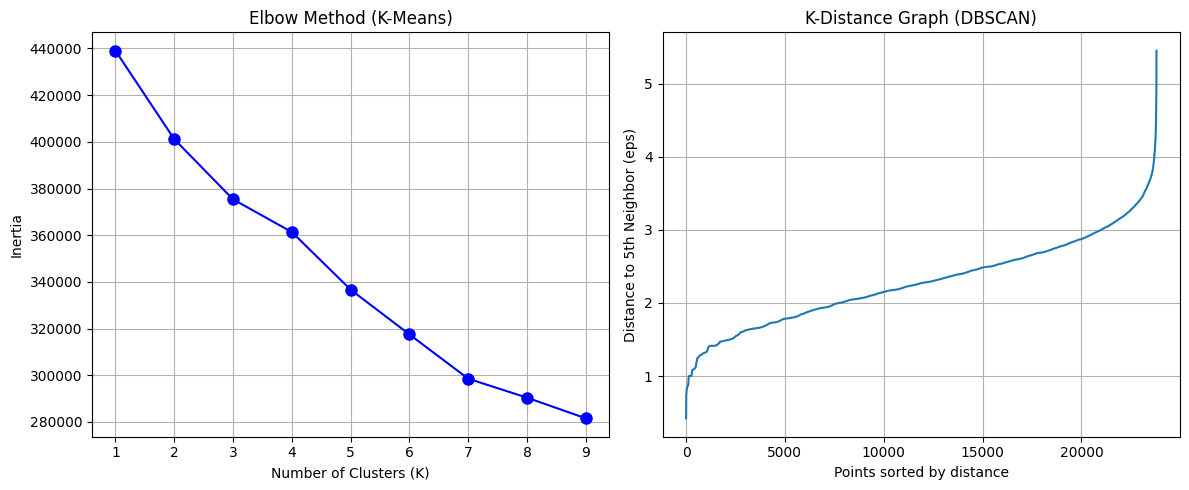

In [15]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# --- 1. K-Means Optimization (Elbow Method) ---
print("Calculating Elbow Method for K-Means...")
inertia = []
K_range = range(1, 10)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_unsupervised)
    inertia.append(km.inertia_)

plt.figure(figsize=(12, 5))

# Plot Elbow
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.title('Elbow Method (K-Means)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)

# --- 2. DBSCAN Optimization (K-Distance Graph) ---
print("Calculating K-Distance Graph for DBSCAN...")
# נשתמש ב-5 שכנים כי זה ה-min_samples שהגדרנו
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_unsupervised)
distances, indices = neighbors_fit.kneighbors(X_unsupervised)

# מיון המרחקים מהקטן לגדול
distances = np.sort(distances[:, 4], axis=0)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('K-Distance Graph (DBSCAN)')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to 5th Neighbor (eps)')
plt.grid(True)

plt.tight_layout()
plt.show()

K-Means (Elbow Method): בגרף ניתן לראות ירידה חדה ב-Inertia עד לאזור של K=2 או K=3. לאחר מכן השיפור מתמתן (ה"מרפק"). זה מאשש שהחלוקה לשתי קבוצות עיקריות (שראינו שיש ביניהן הבדל באחוז מקרי הרצח) היא נכונה מתמטית.

DBSCAN (K-Distance Graph): הגרף מראה את "נקודת הברך" (Knee) באזור של מרחק (Distance) שבין 2.5 ל-3.0. זהו ה-eps האידיאלי. העובדה שהשתמשנו בערך קרוב לכך מסבירה מדוע המודל הצליח לזהות 35 מוקדי פשיעה צפופים תוך סינון רעשים סטטיסטיים.